In [ ]:
# We'll need to update our path to import from Drive.
# import sys
# sys.path.append('/content/drive/MyDrive/2021_DMCT/datos_eeg/crudos')

# **Importa paquetes**



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import matplotlib.gridspec as gridspec
from scipy.signal import butter, lfilter
from sklearn import decomposition

import mne

Bajo paquete para trabajar con EEG- Me permite ver la topografía

## (1) Levanto datos de EEG

El registro de EEG de 30 canales viene en formato txt. La frecuencia de muestreo es de 256 Hz.

In [3]:
filename = 'Originals/crudos/suj_1_bl_1_crudos.txt'

datos = pd.read_csv(filename, sep=',', header=None)

EEGdata = datos.to_numpy()

srate = 256
ch = EEGdata.shape[0]
samples = EEGdata.shape[1] 

print("Sampling rate: {:.2f} Hz".format(srate))
print("Data shape: {:d} samples x {:d} channels".format(EEGdata.shape[1], EEGdata.shape[0]))
print("Tiempo total : {:.2f} ".format(samples/srate))

Sampling rate: 256.00 Hz
Data shape: 30720 samples x 30 channels
Tiempo total : 120.00 


Los registros fueron tomados con el montage 10-20. Tengo que armarlo que los electrodos tengan esta distribución:
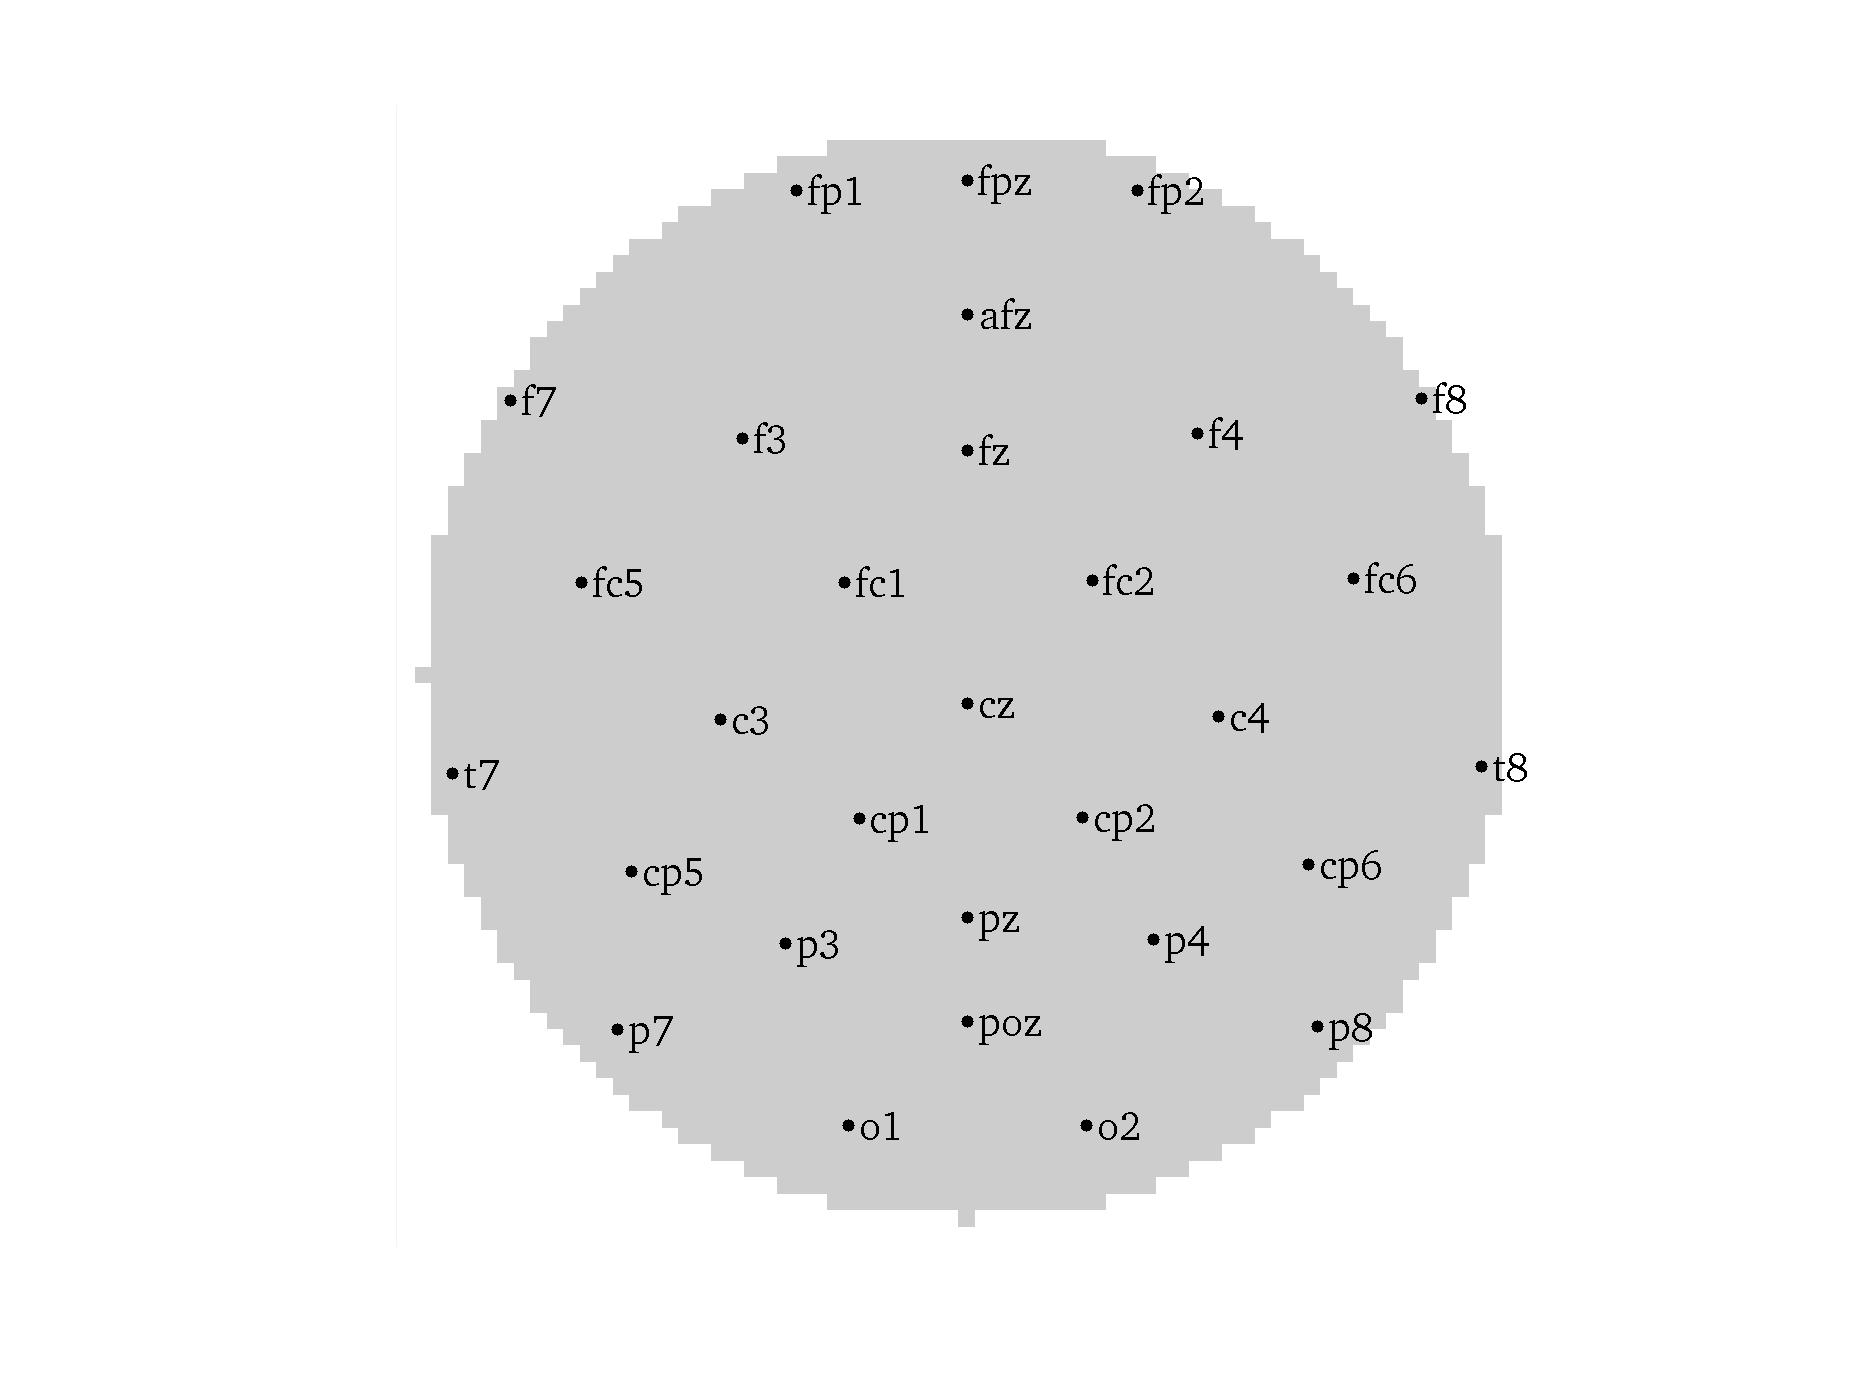

In [4]:
# Montage 10-20
mont1020 = mne.channels.make_standard_montage('standard_1020')

# Elijo canales que tengo
kept_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
                 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
                 'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz']

ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]

mont1020_30 = mont1020.copy()

# Me quedo solo con los canales seleccionados
mont1020_30.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]

# Me quedo con las referencias desde dónde están ubicados los canales
mont1020_30.dig = mont1020.dig[0:3]+kept_channel_info
info_eeg = mne.create_info(ch_names=mont1020_30.ch_names, sfreq=128,
                            ch_types='eeg').set_montage(mont1020_30)

# (1.bis) Inspección de los datos crudos

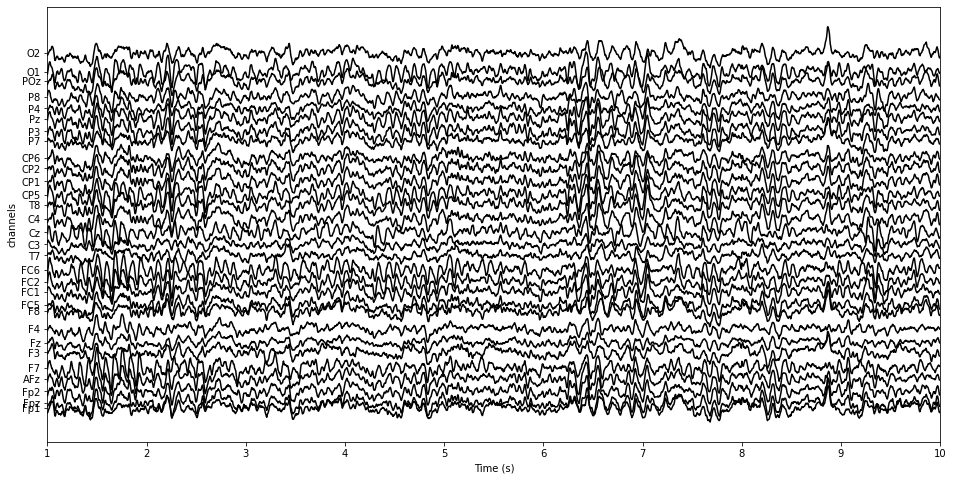

In [5]:
inicio = 1
fin = 10

xticks = np.arange(inicio*srate, (fin+1)*srate,srate)
fig,ax = plt.subplots(ncols=1,figsize=(16,8))
#fig.suptitle('Series temporales (uV)')
yticks=[]

for c in np.arange(ch):
    temp = EEGdata[c,inicio*srate:fin*srate]
    dmin=np.min(temp)
    dmax=np.max(temp)
    vmedio = np.mean([dmin,dmax])+30*c
    yticks.append(vmedio)
    ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'k')
ax.set_xlim([inicio*srate,fin*srate])
ax.set_xticks(xticks)
ax.set_xticklabels(np.arange(inicio,fin+1))
ax.set_yticks(yticks)
ax.set_yticklabels(mont1020_30.ch_names)
ax.set_ylabel('channels')
ax.set_xlabel('Time (s)')
  
plt.show()

## (2) Pre-procesado

Defino un filtro Butterworth de 6to orden que a partir de Scipy. Filtro entre 1 y 35 Hz
 contains a zero-phase 6-th order Butterworth band-pass filter as provided by SciPy. The input is (1) the data to be filtered as a NumPy array of shape (n_samples, n_channels), (2) a tuple defining the desired frequency band in Hz, and (3) the EEG sampling rate in Hz.

In [6]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



# Sample rate and desired cutoff frequencies (in Hz).
lowcut = 2
highcut = 20
order = 6
EEGdata_filt = np.zeros_like(EEGdata)
for i, temp_canal in enumerate(EEGdata):
    EEGdata_filt[i,:] = butter_bandpass_filter(temp_canal, lowcut, highcut, srate, order)

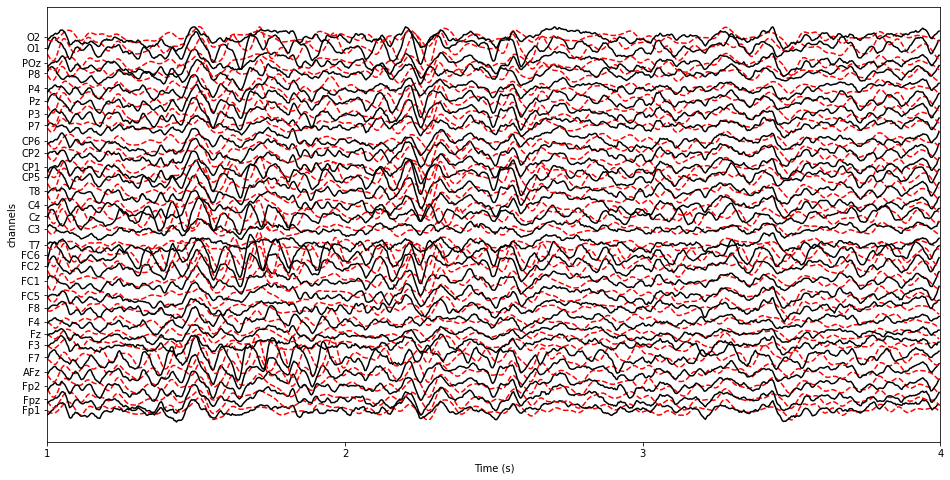

In [7]:
inicio = 1
fin = 4

xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
fig,ax = plt.subplots(ncols=1,figsize=(16,8))
#fig.suptitle('Series temporales (uV)')
yticks=[]

for c in np.arange(ch):
    temp = EEGdata_filt[c,inicio*srate:fin*srate]
    temp2 = EEGdata[c,inicio*srate:fin*srate]
    dmin = np.min(temp)
    dmax = np.max(temp)
    vmedio = np.mean([dmin,dmax])+30*c
    yticks.append(vmedio)
    ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'--r')
    ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp2)+temp2,'k')
    
ax.set_xlim([inicio*srate,fin*srate])
ax.set_xticks(xticks)
ax.set_xticklabels(np.arange(inicio,fin+1))
ax.set_yticks(yticks)
ax.set_yticklabels(mont1020_30.ch_names)
ax.set_ylabel('channels')
ax.set_xlabel('Time (s)')
  
plt.show()

Text(0.5, 0, 'Time (s)')

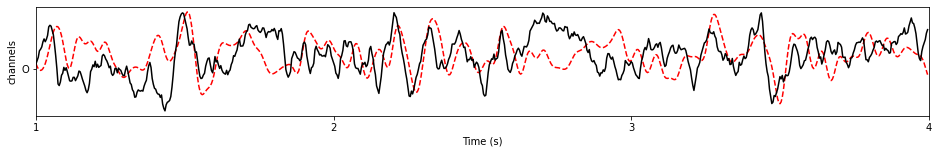

In [8]:
fig,ax=plt.subplots(ncols=1,figsize=(16,2))
ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'--r')
ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp2)+temp2,'k')
ax.set_xlim([inicio*srate,fin*srate])
ax.set_xticks(xticks)
ax.set_xticklabels(np.arange(inicio,fin+1))
ax.set_yticks([860])
ax.set_yticklabels(mont1020_30.ch_names[c-1])
ax.set_ylabel('channels')
ax.set_xlabel('Time (s)')
  

Topología


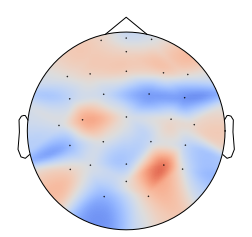

In [9]:
fig, ax = plt.subplots(figsize=(8, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)


im,cm   = mne.viz.plot_topomap(EEGdata_filt[:,inicio*srate:fin*srate].mean(axis=1),info_eeg,vmin=-0.05,vmax=0.3,
                     cmap='coolwarm', contours=0, show=True)
ax.set_title('topogragía promedio')
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
    #clb.ax.set_title(unit_label,fontsize=fontsize) # title on top of colorbar
   # plt.show()     

## (3) Descomposición (PCA-1)

(30, 3)


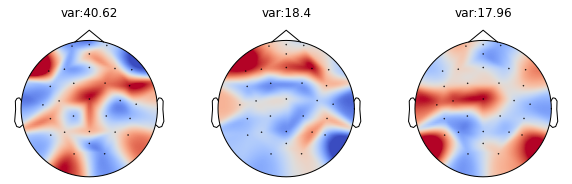

In [10]:
pca = decomposition.PCA(n_components=3)
pca.fit(EEGdata_filt)
pcs = pca.transform(EEGdata_filt)
print(pcs.shape)
var = pca.explained_variance_ratio_
fig2, ax = plt.subplots(ncols=pcs.shape[1], figsize=(10, 3), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for p in range(pcs.shape[1]):
  mne.viz.plot_topomap(pcs[:,p],
                    info_eeg,
                    cmap='coolwarm', contours=0,
                    axes=ax[p],show=False)
  ax[p].set_title('var:'+str(round(var[p]*100,2)) )      

If you have arrived here, you should have completed the tutorial successfully. You should be familiar with the functionality provided by this software and have a good impression how to process larger data sets to obtain group statistics.


# Calculate GFP

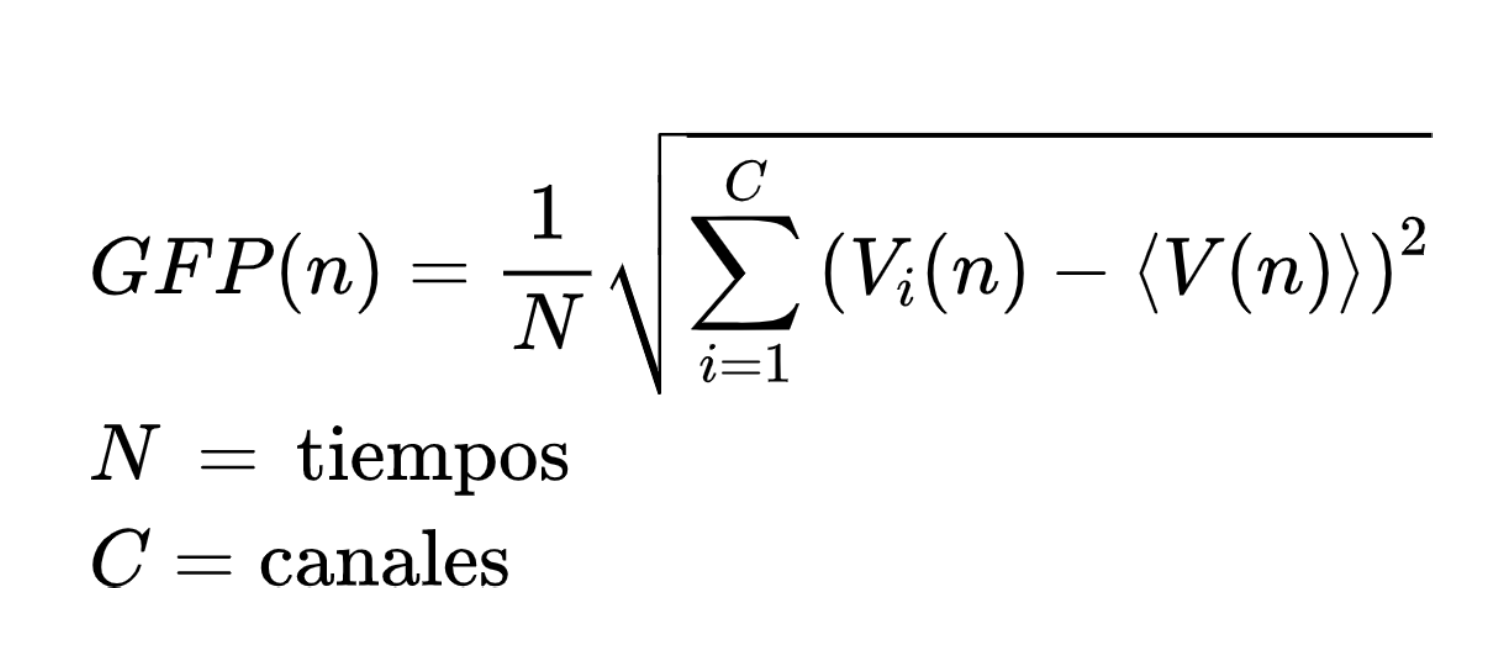